In [2]:
# Imports
from glrm.loss import QuadraticLoss, HingeLoss, OrdinalLoss
from glrm.reg import QuadraticReg
from glrm.glrm import GLRM
from glrm.util import pplot
from glrm.convergence import Convergence
from numpy.random import randn, choice, seed
from numpy import sign, ceil, hstack
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import math
import cvxpy as cp
from statistics import mean, stdev

from sklearn.cluster import KMeans
import pandas as pd

## Code for experiments

In [3]:
class NormalisedRMSErr():
    def __call__(self, A, A_hat): 
        #Normalize by the standard deviation of each column
        mask = np.tile(np.std(A, axis=0), (len(A), 1))
        A_diff = np.divide((A - A_hat), mask)
        return math.sqrt(np.mean(np.square(A_diff)))

class OrdErr():
    def __call__(self, A, A_hat): 
        A_diff = np.abs(A - A_hat)
        return np.sum(np.vectorize(cumu_sum)(A_diff)) / A_diff.size

class ClassErr():
    def __call__(self, A, A_hat): 
        A_diff = A - A_hat
        return np.count_nonzero(A_diff) / A_diff.size
    
class CategoricalClassErr():
    def __init__(self, decoder):
        self.decoder = decoder
    def __call__(self, A, A_hat): 
        A_diff = A - A_hat
        return np.count_nonzero(A_diff) / (A_diff.shape[0]*len(self.decoder)*2)
    
def cumu_sum(x):
    return sum(i+1 for i in range(int(x)))

In [4]:
def k_vary_exp(A, loss, regX, regY, converge, ns, pred_errs, k_exp_list, exp_name, iterations, decoder=None, mode='w'):
    # Compute average of errors for each rank
    file_path = 'clustering_exp_outputs/'+ exp_name + '.txt'
    if os.path.exists(file_path):
          os.remove(file_path)
    cumsum_ns = np.insert(np.cumsum(ns), 0,0)
    k_list = []
    mean_errs = [[] for i in range(len(ns))]
    std_dev_errs = [[] for i in range(len(ns))]
    
    # Make sure all your effort is not lost if something does happen to go wrong
    try:
        for k_model in k_exp_list:
            with open(file_path, 'a+') as file:
                file.write('----- RANK {} -----\n'.format(k_model))
            k_fixed_errs = [[] for i in range(len(ns))]
            for i in range(iterations):
                try:
                    model = GLRM(A, loss, regX, regY, k_model, converge = converge, obj_type = 1, decoder=decoder)
                    model.fit();
                    print('Error here')
                    A_hat = model.predict() # prediction matrix
                    print('Or here?')
                    for j in range(len(ns)):
                        k_fixed_errs[j].append(pred_errs[j](A[j], A_hat[:, cumsum_ns[j]:cumsum_ns[j+1]]))
                except:
                    with open(file_path, 'a+') as file:
                        file.write('Error encountered on iteration {}\n'.format(i))
                    pass
            if len(k_fixed_errs[0]) != 0:
                k_list.append(k_model)
                for j in range(len(ns)):
                    mean_errs[j].append(mean(k_fixed_errs[j]))
                    std_dev_errs[j].append(stdev(k_fixed_errs[j]))
                with open(file_path, 'a+') as file:
                    file.write('Mean Prediction Errors - ' + str([m[-1] for m in mean_errs]) + '\n')
                    file.write('Std Dev - ' + str([s[-1] for s in std_dev_errs]) + '\n')
    except:
        print('Experiment terminated prematurely. Saving history...')

    # Save data to dataframe for future use
    data = {
        "Rank" : k_list,
    }
    for i in range(len(ns)):
        data['Mean Error {}'.format(i+1)] = mean_errs[i]
        data['Std Dev {}'.format(i+1)] = std_dev_errs[i]
    df = pd.DataFrame.from_dict(data)
    
    if mode == 'a':
        header = False
    elif mode == 'w':
        header = True
    df.to_csv('clustering_exp_outputs/'+ exp_name + '.csv', mode=mode, header=header)
    
    return k_list, mean_errs, std_dev_errs

## K-means clustering of synthetic data 1

In [2]:
seed(1)
# Generate problem data
m, k = 150, 8
n1 = 15 # cols of numerical data
n2 = 15 # cols of ordinal data
n3 = 15 # cols of boolean data
ns = [n1, n2, n3]
n = n1+n2+n3
data = randn(m,k).dot(randn(k,n))
data_real = data[:,:n1] # numerical data
data_ord = data[:,n1:n1+n2] 
data_ord = data_ord - data_ord.min() # scale data to be 0 or larger
data_ord = (data_ord/data_ord.max()*6 + 1).round()# round numbers spanning 1 to 7 ordinal data, e.g., 7 point Likert scale
data_bool = sign(data[:,n1+n2:])

# Initialize model
A = [data_real, data_ord, data_bool]
loss = [QuadraticLoss, OrdinalLoss, HingeLoss]
regX, regY = QuadraticReg(0.01), QuadraticReg(0.01)
converge = Convergence(TOL = 1e-3, max_iters = 1000, max_buffer=10) # optional (default TOL = 1e-3)

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/GLRM-0.0.1-py3.8.egg/glrm/glrm.py:216: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplica

---------- ITERATION 0 ----------


/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Residual norm for X minimization: 2409.8435929917123
Residual norm for Y minimization: 130.54073115249463
Residual norm for Y minimization: 1033.9196837105824
Residual norm for Y minimization: 492.97134063518
---------- ITERATION 1 ----------
Residual norm for X minimization: 1680.594257316594
Residual norm for Y minimization: 120.78586663210098
Residual norm for Y minimization: 1004.0531656377626
Residual norm for Y minimization: 412.6171219045293
---------- ITERATION 2 ----------
Residual norm for X minimization: 1610.3182060549132
Residual norm for Y minimization: 110.01747704508644
Residual norm for Y minimization: 981.0268397481764
Residual norm for Y minimization: 429.69638229481836
---------- ITERATION 3 ----------
Residual norm for X minimization: 1586.468219148084
Residual norm for Y minimization: 109.8938003400933
Residual norm for Y minimization: 971.3253992374812
Residual norm for Y minimization: 434.48847707279145
---------- ITERATION 4 ----------
Residual norm for X minim

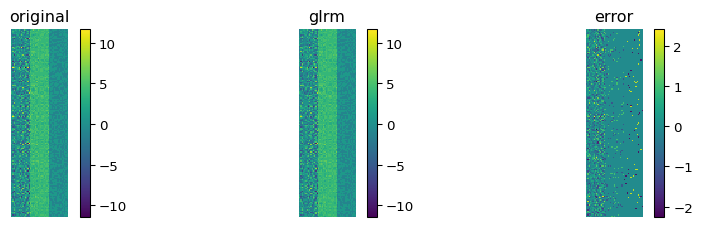

In [3]:
# Example for rank 8
model = GLRM(A, loss, regX, regY, 8, converge = converge, obj_type = 1)
model.fit()

X, Y = model.factors()
A_hat = model.predict() # glrm_pca.predict(X, Y) works too; returns decode(XY)
A_diff = hstack(A)-A_hat # original A minus predicted A
pplot([hstack(A), A_hat, A_diff], ["original", "glrm", "error"])

## Visualize potential clusters from new sample vectors

In [50]:
# Analysis of variance explained by each generalised principal component??
# Not sure how to do that, so I am calculating the standardized loss for when the predicted matrix is only comprised 
# of one component, and doing that for all components
k=8
component_losses = []

for i in range(k):
    A_part = np.outer(X[:, i], Y[i, :]) + np.outer(X[:, -1], Y[-1, :])
    A_part = [A_part[:, :15], A_part[:, 15:30], A_part[:, 30:]]
    tot_loss = sum([L(Aj, A_partj, mask=np.reciprocal(np.square(mask))) for L, Aj, A_partj, mask in zip(model.L, A, A_part, model.masks)]).value
    component_losses.append(tot_loss)

In [51]:
print(component_losses)

[5933.1073095275515, 6277.834100832425, 6407.076401686157, 6568.676523599649, 6681.050389577044, 6846.597218069857, 6925.351488776513, 6968.884060936165]


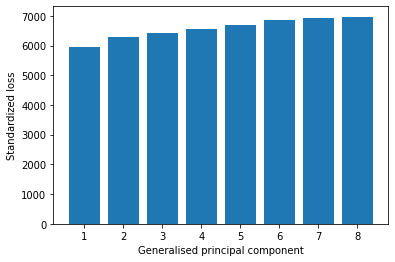

In [55]:
# Plot each component's loss

plt.bar(list(range(1, 9)), component_losses)
plt.xlabel('Generalised principal component')
plt.ylabel('Standardized loss')
plt.show()

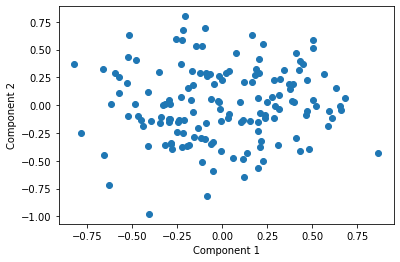

In [56]:
x1 = X[:, 0]
x2 = X[:, 1]

plt.scatter(x1, x2)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

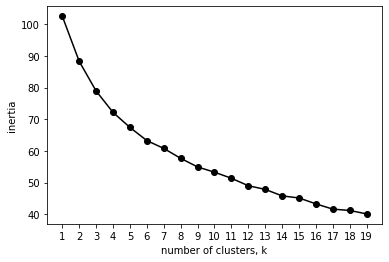

In [39]:
# Initial synthetic data used for model rank study

ks = range(1, 20)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    km_model = KMeans(n_clusters=k)
    
    # Fit model to samples
    km_model.fit(X)
    
    # Append the inertia to the list of inertias
    inertias.append(km_model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

It is likely we just don't have clusters.

## K-means clustering for synthetic data 2

The synthetic data generated here is purposely clustered.

In [13]:
# Initialize parameters
num_clusters = 4
centre_std = 5
cluster_points = 40
m = cluster_points*num_clusters

std_real = 2
std_ord = 0.8
p_bool = 0.2

n1 = 10 # cols of numerical data
n2 = 10 # cols of ordinal data
n3 = 10 # cols of boolean data
ns = [n1, n2, n3]
n = n1+n2+n3

# Initialize 'cluster centres' (these are not true cluster centres because of limits to ord and bool data)
seed(1)
centres = np.random.normal(0, centre_std, size=(num_clusters, n))
centres_real = centres[:,:n1] # numerical data
centres_ord = centres[:,n1:n1+n2] 
centres_ord = centres_ord - centres_ord.min() # scale data to be 0 or larger
centres_ord = (centres_ord/centres_ord.max()*6 + 1).round()# round numbers spanning 1 to 7 ordinal data, e.g., 7 point Likert scale
centres_bool = sign(centres[:,n1+n2:])

# Add some noise to each cluster centre
seed(2)
data_real = np.tile(centres_real,(cluster_points,1)) \
            + np.random.normal(0, std_real, size=(m, n1))
seed(3)
data_ord = (np.tile(centres_ord, (cluster_points,1)) \
            + np.random.normal(0, std_ord, size=(m, n2))).round()
data_ord[data_ord < 1] = 1
data_ord[data_ord > 7] = 7
data_bool = np.tile(centres_bool, (cluster_points,1))
seed(4)
data_bool[np.random.rand(*data_bool.shape) < p_bool] *= -1

# Reorder resulting arrays to get rid of structure
shuffle_list = list(range(m))
random.Random(1).shuffle(shuffle_list)
data_real = data_real.take(shuffle_list, 0)
data_ord = data_ord.take(shuffle_list, 0)
data_bool = data_bool.take(shuffle_list, 0)

# Initialize model
A = [data_real, data_ord, data_bool]
loss = [QuadraticLoss, OrdinalLoss, HingeLoss]
regX, regY = QuadraticReg(0.01), QuadraticReg(0.01)
converge = Convergence(TOL = 1e-3, max_iters = 1000, max_buffer=10) # optional (default TOL = 1e-3)

In [19]:
# Initialize experiment params
pred_errs = [NormalisedRMSErr(), OrdErr(), ClassErr()]
k_exp_list = list(range(1, 11)) + list(range(12, 21, 2)) + list(range(25, 31, 5))
exp_name = '25-11-syn-cluster-1'
iterations = 5

In [20]:
%%capture
# Vary rank k for this dataset to find the best rank for model
k_list, mean_errs, std_dev_errs = k_vary_exp(A, loss, regX, regY, converge, ns, pred_errs, k_exp_list, exp_name, iterations)

In [6]:
# Load data from csv

df = pd.read_csv('clustering_exp_outputs/25-11-syn-cluster-1.csv')
k_list = df['Rank']
mean_errs = [df[h] for h in list(df) if 'Mean' in h]
std_dev_errs = [df[h] for h in list(df) if 'Std' in h]

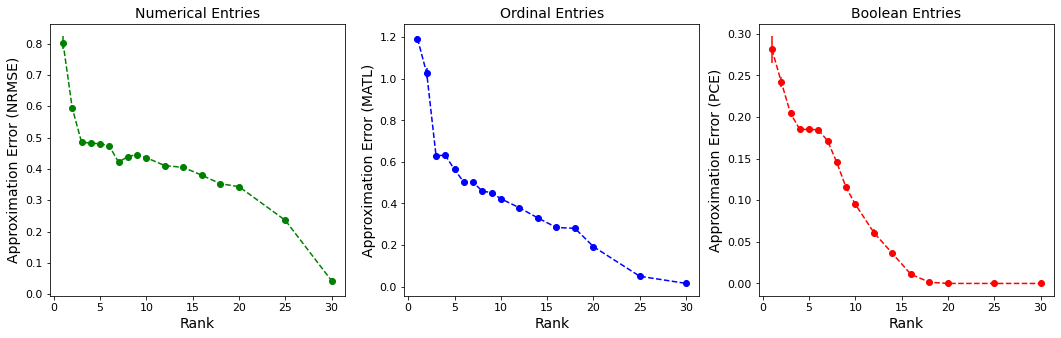

In [10]:
# Plot graphs

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.errorbar(k_list, mean_errs[0], yerr=std_dev_errs[0], fmt='go--')
ax1.set_title('Numerical Entries', fontsize=14)
ax1.set_xlabel('Rank', fontsize=14)
ax1.set_ylabel('Approximation Error (NRMSE)', fontsize=14)
ax2.errorbar(k_list, mean_errs[1], yerr=std_dev_errs[1], fmt='bo--')
ax2.set_title('Ordinal Entries', fontsize=14)
ax2.set_xlabel('Rank', fontsize=14)
ax2.set_ylabel('Approximation Error (MATL)', fontsize=14)
ax3.errorbar(k_list, mean_errs[2], yerr=std_dev_errs[2], fmt='ro--')
ax3.set_title('Boolean Entries', fontsize=14)
ax3.set_xlabel('Rank', fontsize=14)
ax3.set_ylabel('Approximation Error (PCE)', fontsize=14)
plt.show()
#plt.savefig('clustering_exp_outputs/25-11-syn-cluster-1-rank.pdf')

So this is very interesting. Boolean data was well fitted before ordinal data, which was well fitted before the real-numbered data. 

2 elbows observed for boolean data, one at rank 4-6, the other at rank 18.

### Attempt clustering with rank 4 model

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/GLRM-0.0.1-py3.8.egg/glrm/glrm.py:220: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplica

---------- ITERATION 0 ----------


/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Residual norm for X minimization: 2464.2999766199437
Residual norm for Y minimization: 375.85811593846785
Residual norm for Y minimization: 908.5114403400744
Residual norm for Y minimization: 867.4606910242842
---------- ITERATION 1 ----------
Residual norm for X minimization: 2050.1188511057694
Residual norm for Y minimization: 380.3026908649898
Residual norm for Y minimization: 907.5729004773341
Residual norm for Y minimization: 769.6010014963491
---------- ITERATION 2 ----------
Residual norm for X minimization: 2031.407409815319
Residual norm for Y minimization: 378.9546560619545
Residual norm for Y minimization: 904.292879630333
Residual norm for Y minimization: 767.3814820427181
---------- ITERATION 3 ----------
Residual norm for X minimization: 2022.7554953145996
Residual norm for Y minimization: 377.6083339223424
Residual norm for Y minimization: 901.2072993075844
Residual norm for Y minimization: 767.0096805618174
---------- ITERATION 4 ----------
Residual norm for X minimizat

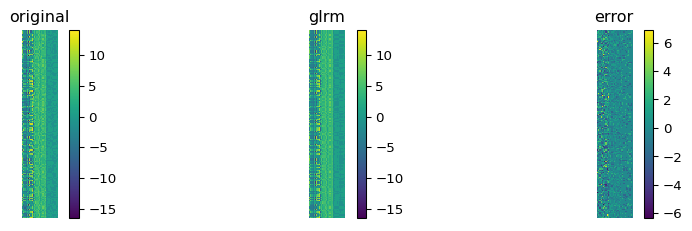

In [14]:
# Train rank  model
model_rank = 4

model = GLRM(A, loss, regX, regY, model_rank, converge = converge, obj_type = 1)
model.fit()

X, Y = model.factors()
A_hat = model.predict() # glrm_pca.predict(X, Y) works too; returns decode(XY)
A_diff = hstack(A)-A_hat # original A minus predicted A
pplot([hstack(A), A_hat, A_diff], ["original", "glrm", "error"])

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


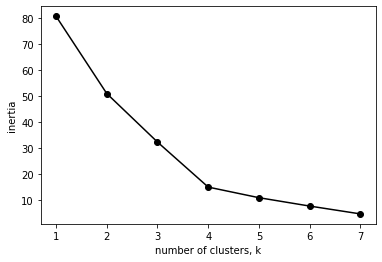

In [15]:
# Vary number of clusters to obtain cluster inertias, and determine optimal number of clusters

ks = range(1, 8)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    km_model = KMeans(n_clusters=k)
    
    # Fit model to samples
    km_model.fit(X)
    
    # Append the inertia to the list of inertias
    inertias.append(km_model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()
#plt.savefig('clustering_exp_outputs/25-11-syn-cluster-1-kmeans-inertias.png')

In [16]:
# Obtain and plot clusters for k=4
km_model = KMeans(n_clusters=4, random_state=0).fit(X)
km_labels = km_model.labels_
km_centres = km_model.cluster_centers_

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
# Find out which cluster centre corresponds to which initialization cluster centre
init_centres = hstack([centres_real, centres_ord, centres_bool])
new_centres = np.dot(km_centres, Y)

print(init_centres)
print(new_centres)

[[  8.12172682  -3.05878207  -2.64085876  -5.36484311   4.32703815
  -11.50769348   8.72405882  -3.8060345    1.59519548  -1.24685188
    6.           1.           4.           3.           6.
    2.           4.           3.           4.           5.
   -1.           1.           1.           1.           1.
   -1.          -1.          -1.          -1.           1.        ]
 [ -3.45830376  -1.98376763  -3.4358635   -4.22602821  -3.35623065
   -0.06332299  -5.58655174   1.17207849   8.29901089   3.7102208
    4.           3.           3.           6.           4.
    3.           4.           7.           4.           5.
    1.          -1.          -1.          -1.          -1.
    1.           1.           1.           1.           1.        ]
 [ -3.7719897    6.26434078   2.5646491   -1.49046418   2.44259073
   -0.37785857   5.65814694   7.59908408  10.92787703  -6.98248168
    2.           3.           4.           5.           4.
    1.           4.           5.           4.     

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Difference in cluster assignment numbers between initial and new clusters**

init 0 -> new 0 \
init 1 -> new 2 \
init 2 -> new 1 \
init 3 -> new 3

In [18]:
# Compare initial labels (corresponding to cluster centre initialisation) with clustering labels

# Get initial labels
init_labels = np.tile(np.array([0, 1, 2, 3]), cluster_points)
init_labels = init_labels.take(shuffle_list, 0)

# Swap cluster numbers 1 and 2 from new cluster labels
new_labels = km_labels.copy()
for i in range(len(new_labels)):
    if new_labels[i] == 2:
        new_labels[i] = 1
    elif new_labels[i] == 1:
        new_labels[i] = 2

# Find percentage of same clustering assignments
percent_same_cluster = sum(init_labels == new_labels)/len(init_labels)
percent_same_cluster

0.5

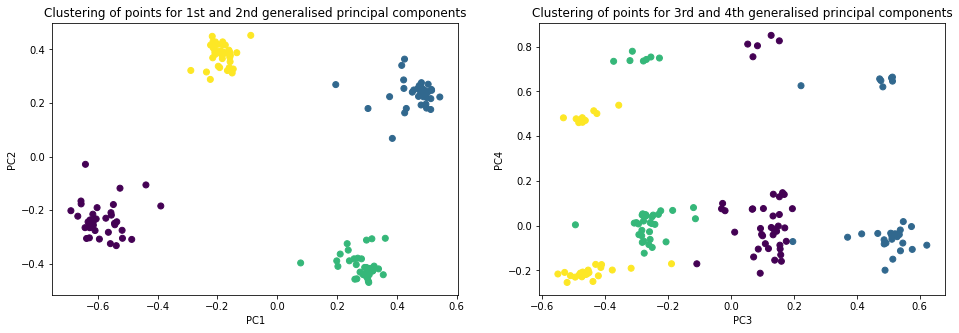

In [19]:
# Visualize the clusters

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax[0].scatter(X[:, 0],X[:, 1], c=init_labels)
ax[0].set_title('Clustering of points for 1st and 2nd generalised principal components')
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].scatter(X[:, 2],X[:, 3], c=init_labels)
ax[1].set_title('Clustering of points for 3rd and 4th generalised principal components')
ax[1].set_xlabel('PC3')
ax[1].set_ylabel('PC4')
plt.show()
#plt.savefig('clustering_exp_outputs/25-11-syn-cluster-1-pca-clusters.png')

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


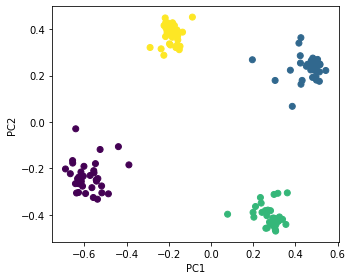

In [23]:
plt.figure(figsize=(5, 4))
plt.scatter(X[:, 0],X[:, 1], c=init_labels)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.savefig('clustering_exp_outputs/syn-cluster-pc12.pdf')

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


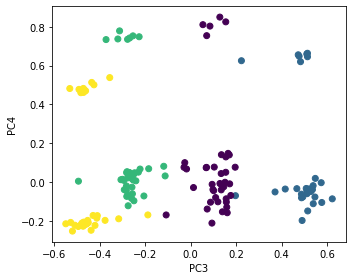

In [24]:
plt.figure(figsize=(5, 4))
plt.scatter(X[:, 2],X[:, 3], c=init_labels)
plt.xlabel('PC3')
plt.ylabel('PC4')
plt.tight_layout()
plt.savefig('clustering_exp_outputs/syn-cluster-pc34.pdf')

100% of the points were clustered by k-means to correspond to the 'cluster centres' from which they were initialized.

In fact, from the visualization of the clusters plotted two principal components at a time, we can see that only two principal components would really have been necessary to cluster the data appropriately.

### Baseline clustering method 1
Cluster with real-numbered (regular) kmeans using numerical representation of A.

In [149]:
# Obtain and plot clusters for k=4
bl1_model = KMeans(n_clusters=4, random_state=0).fit(np.hstack(A))
bl1_labels = bl1_model.labels_
bl1_centres = bl1_model.cluster_centers_

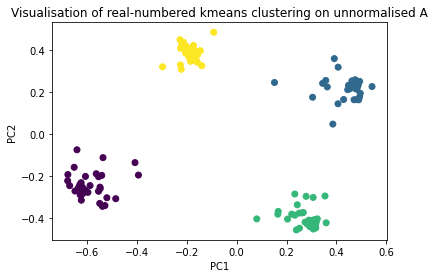

In [151]:
# Visualize the clusters
plt.scatter(X[:, 0],X[:, 1], c=bl1_labels)
plt.title('Visualisation of real-numbered kmeans clustering on unnormalised A')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('clustering_exp_outputs/1-12-syn-cluster-1-baseline-1.png')

### Baseline clustering method 2
Cluster with real-numbered (regular) kmeans using standardized numerical representation of A.

In [152]:
mu = np.tile(np.mean(np.hstack(A), axis=0), (A[0].shape[0], 1))
std = np.tile(np.std(np.hstack(A), axis=0), (A[0].shape[0], 1))

# Obtain and plot clusters for k=4
bl2_model = KMeans(n_clusters=4, random_state=0).fit((np.hstack(A) - mu)/std)
bl2_labels = bl2_model.labels_
bl2_centres = bl2_model.cluster_centers_

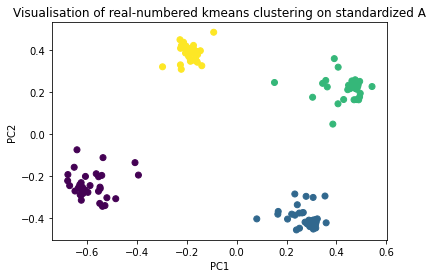

In [203]:
# Visualize the clusters
plt.scatter(X[:, 0],X[:, 1], c=bl2_labels)
plt.title('Visualisation of real-numbered kmeans clustering on standardized A')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('clustering_exp_outputs/1-12-syn-cluster-1-baseline-2.png')

### Baseline clustering method 3
Cluster with generalized kmeans.

In [72]:
test = np.array([[1, 2], [3, 4]])
test[0].shape

(2,)

In [146]:
bl1_centres.shape

(4, 5)

In [145]:
np.hstack(A).shape

(160, 30)

In [99]:
def plus_plus(A, loss, mask, k, random_state=12):
    """
    Create cluster centroids using the k-means++ algorithm.
    Parameters
    ----------
    ds : numpy array
        The dataset to be used for centroid initialization.
    k : int
        The desired number of clusters for which centroids are required.
    Returns
    -------
    centroids : numpy array
        Collection of k centroids as a numpy array.
    Inspiration from here: https://stackoverflow.com/questions/5466323/how-could-one-implement-the-k-means-algorithm
    """
    m = A[0].shape[0]
    ns = [Aj.shape[1] for Aj in A]
    cumsum_ns = np.cumsum(ns)[:-1]
    
    ds = np.hstack(A)
    
    np.random.seed(random_state)
    centroids = [ds[0]]
    centroid_indexes = [0]

    for _ in range(1, k):
        # For each sample, caculate minimum distance from a centroid
        dist_sq = np.array([min([sum(L(Aj[i], cj, mask=lm[0]).value for L, Aj, lm, cj in zip(loss, A, mask, np.split(centroid, cumsum_ns))) 
                             for centroid in centroids]) 
                    for i in range(m)])

        probs = dist_sq/dist_sq.sum() # Probability of choosing each sample as centroid 
        cumulative_probs = probs.cumsum()
        
        while True:
            r = np.random.rand() # Random number between 0 and 1 from uniform distribution
            for j, p in enumerate(cumulative_probs):
                if r < p:
                    i = j
                    break
            
            if i not in centroid_indexes:
                centroids.append(ds[i])
                centroid_indexes.append(i)
                break

    return np.array(centroids)


In [101]:
def generalised_kmeans(A, loss, mask, k, max_iter=100, tol=10**(-2), random_state=12):
    
    m = A[0].shape[0]
    ns = [Aj.shape[1] for Aj in A]
    cumsum_ns = np.cumsum(ns)[:-1]
    n = sum(ns)
    
    iterations = 0
    
    # Initialize cluster centroids
    centroids = plus_plus(A, loss, mask, k, random_state) # TODO IMPROVE INITIALIZATION
    new_centroids = np.zeros((k, n))
    
    # Initialize array to store clusters
    clusters = np.zeros(m)
    
    prev_diff_centroids = 0
    
    # Iterate until stopping criteria
    while iterations < max_iter:
        iterations += 1
        
        # Assign each datapoint to closest centroid
        for i in range(m):
            dist = np.array([sum(L(Aj[i], c, mask=lm[0]).value for L, Aj, lm, c in zip(loss, A, mask, np.split(centroid, cumsum_ns))) 
                             for centroid in centroids])
            clusters[i] = np.argmin(dist)
        
        # Move centroids to minimize within-cluster loss
        for i in range(k):
            cv = [cp.Variable(ni) for ni in ns]
            A_clus = [np.array([A[l][j,:] for j in range(m) if clusters[j] == i]) for l in range(len(A))]
            m_clus = np.sum(clusters == i)
            obj_func = sum(sum(L(samp, c, mask=lm[0]) for samp in Aj) 
                      for L, Aj, lm, c in zip(loss, A_clus, mask, cv))
            prob = cp.Problem(cp.Minimize(obj_func))
            obj = prob.solve(solver=cp.SCS, eps=1e-2, max_iters=100, use_indirect=False, warm_start=False)
            new_centroids[i] = np.hstack([c.value for c in cv])
            
        diff_centroids = [sum(L(ncj, ocj, mask=lm[0]).value for L, ncj, ocj, lm in zip(loss, np.split(nc, cumsum_ns), np.split(oc, cumsum_ns), mask)) / n
                         for nc, oc in zip(new_centroids, centroids)]
        
        diff_centroids = mean(diff_centroids)
        if diff_centroids < tol:
            break
        elif abs(diff_centroids - prev_diff_centroids) / diff_centroids < 10**(-2) and iterations != 1:
            break
        else:
            centroids = new_centroids
            prev_diff_centroids = diff_centroids
            print('Iteration {}, convergence score {}'.format(iterations, diff_centroids))
    
    return centroids, clusters
    

In [198]:
bl3_centroids, bl3_clusters = generalised_kmeans(A, model.L, model.loss_masks, 4, max_iter=10)

Iteration 1, convergence score 0.6044320509890506
Iteration 2, convergence score 0.1676430695887087


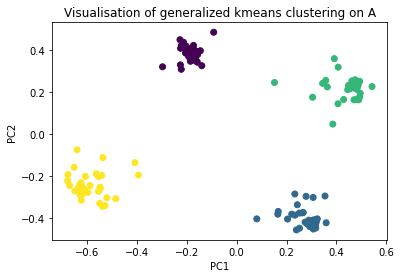

In [202]:
# Visualize the clusters
plt.scatter(X[:, 0],X[:, 1], c=bl3_clusters)
plt.title('Visualisation of generalized kmeans clustering on A')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('clustering_exp_outputs/3-12-syn-cluster-1-baseline-3.png')

## Young People Survey

In [5]:
# Get data for clustering

yp_df = pd.read_csv('datasets/young_people_survey/responses.csv')
yp_df.head()

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,...,20.0,163.0,48.0,1.0,female,right handed,college/bachelor degree,no,village,block of flats
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,...,19.0,163.0,58.0,2.0,female,right handed,college/bachelor degree,no,city,block of flats
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,...,20.0,176.0,67.0,2.0,female,right handed,secondary school,no,city,block of flats
3,5.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,...,22.0,172.0,59.0,1.0,female,right handed,college/bachelor degree,yes,city,house/bungalow
4,5.0,3.0,4.0,3.0,2.0,4.0,3.0,5.0,3.0,1.0,...,20.0,170.0,59.0,1.0,female,right handed,secondary school,no,village,house/bungalow


Columns of interest:
- Music preferences (cols 0 - 18)
- Age (col 140)
- Gender (col 144)
- Village/City (col 148)

In [6]:
m = 1010

# Only use some columns, split them by data type
data_ord = yp_df.iloc[:, list(range(19))].to_numpy()
data_real = np.expand_dims(yp_df.iloc[:, 140].to_numpy(), axis=1)
data_bool = yp_df.iloc[:, [144, 148]].to_numpy()

# Change gender column to boolean, where +1 if male and -1 if female
data_bool[data_bool == 'male'] = 1
data_bool[data_bool == 'female'] = -1
data_bool[data_bool == 'city'] = 1
data_bool[data_bool == 'village'] = -1

# Get missing data lists
missing_ord = [tuple(pos) for pos in np.argwhere(pd.isnull(data_ord))]
missing_real = [tuple(pos) for pos in np.argwhere(pd.isnull(data_real))]
missing_bool = [tuple(pos) for pos in np.argwhere(pd.isnull(data_bool))]

# Convert all Nans to 0
data_ord[pd.isnull(data_ord)] = 2
data_real[pd.isnull(data_real)] = 0
data_bool[pd.isnull(data_bool)] = 0

# Convert boolean data to float
data_bool = data_bool.astype(np.float64)

missing_list = [missing_real, missing_ord, missing_bool]

In [7]:
# Build problem data

A = [data_real, data_ord, data_bool]
loss = [QuadraticLoss, OrdinalLoss, HingeLoss]
regX, regY = QuadraticReg(0.01), QuadraticReg(0.01)
converge = Convergence(TOL = 1e-3, max_iters = 1000, max_buffer=10) # optional (default TOL = 1e-3)

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users

---------- ITERATION 0 ----------


/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Residual norm for X minimization: 13509.683816680732
Residual norm for Y minimization: 885.6969504088445
Residual norm for Y minimization: 11403.663207727745
Residual norm for Y minimization: 1601.143993031939
---------- ITERATION 1 ----------
Residual norm for X minimization: 13034.160310456127
Residual norm for Y minimization: 865.5322356338758
Residual norm for Y minimization: 11298.11263295504
Residual norm for Y minimization: 1551.6332860052453
---------- ITERATION 2 ----------
Residual norm for X minimization: 12845.168559277106
Residual norm for Y minimization: 852.2019987620467
Residual norm for Y minimization: 11173.492937641975
Residual norm for Y minimization: 1496.0165609218657
---------- ITERATION 3 ----------
Residual norm for X minimization: 12813.914306290379
Residual norm for Y minimization: 848.8406056839692
Residual norm for Y minimization: 11158.595155684028
Residual norm for Y minimization: 1476.865453826154
---------- ITERATION 4 ----------
Residual norm for X min

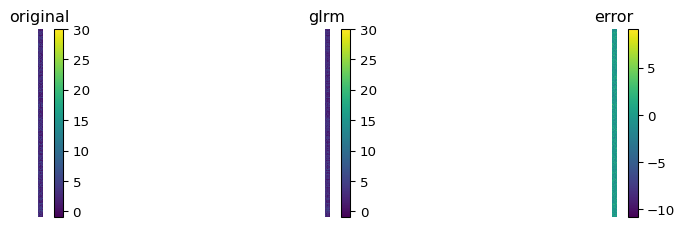

In [30]:
# Train model for rank 5 as a test
yp_model = GLRM(A, loss, regX, regY, 5, missing_list=missing_list, converge = converge, obj_type = 1)
yp_model.fit()

X, Y = yp_model.factors()
A_hat = yp_model.predict() # glrm_pca.predict(X, Y) works too; returns decode(XY)
A_diff = hstack(A)-A_hat # original A minus predicted A
pplot([hstack(A), A_hat, A_diff], ["original", "glrm", "error"])

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


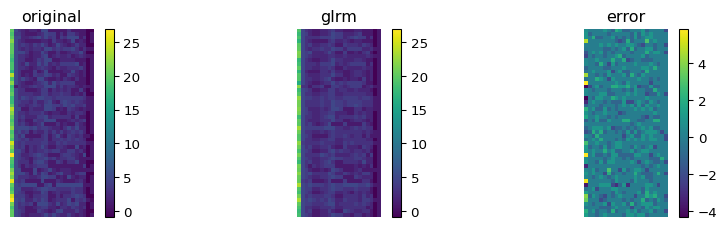

In [31]:
pplot([hstack(A)[:50, :], A_hat[:50, :], A_diff[:50, :]], ["original", "glrm", "error"])

In [13]:
# Initialize experiment params
ns = [1, 19, 2]
pred_errs = [NormalisedRMSErr(), OrdErr(), ClassErr()]
#k_exp_list = list(range(8, 11, 2))
k_exp_list = [8]
exp_name = '13-01-yps-cluster-1'
iterations = 3

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
%%capture
# Vary rank k for this dataset to find the best rank for model
k_list, mean_errs, std_dev_errs = k_vary_exp(A, loss, regX, regY, converge, ns, pred_errs, k_exp_list, exp_name, iterations, mode='a')


In [11]:
df = pd.read_csv('clustering_exp_outputs/13-01-yps-cluster-1.csv')
k_list = df['Rank'].tolist()
mean_errs = [df['Mean Error 1'].tolist(), df['Mean Error 2'].tolist(), df['Mean Error 3'].tolist()] 

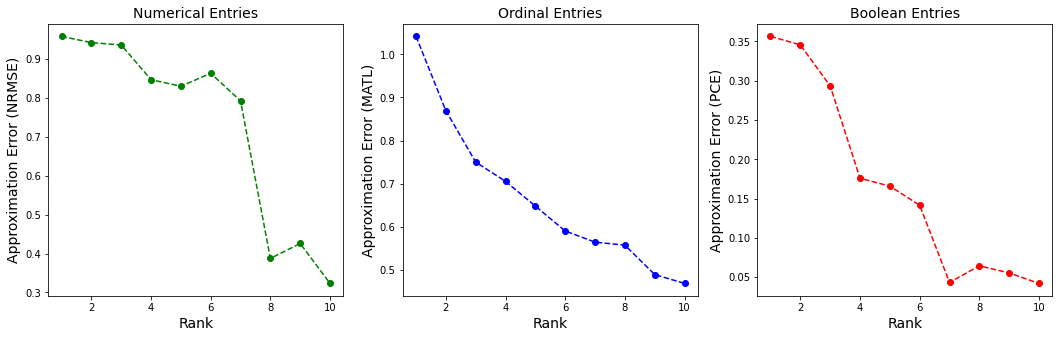

In [12]:
# Plot graphs

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.plot(k_list, mean_errs[0], 'go--')
ax1.set_title('Numerical Entries', fontsize=14)
ax1.set_xlabel('Rank', fontsize=14)
ax1.set_ylabel('Approximation Error (NRMSE)', fontsize=14)
ax2.plot(k_list, mean_errs[1], 'bo--')
ax2.set_title('Ordinal Entries', fontsize=14)
ax2.set_xlabel('Rank', fontsize=14)
ax2.set_ylabel('Approximation Error (MATL)', fontsize=14)
ax3.plot(k_list, mean_errs[2], 'ro--')
ax3.set_title('Boolean Entries', fontsize=14)
ax3.set_xlabel('Rank', fontsize=14)
ax3.set_ylabel('Approximation Error (PCE)', fontsize=14)
#plt.show()
plt.savefig('clustering_exp_outputs/13-01-yps-cluster-1-rank.pdf')

### Clustering with PCA K-means

In [12]:
loss = [QuadraticLoss, QuadraticLoss, QuadraticLoss]
regX, regY = QuadraticReg(0), QuadraticReg(0)
converge = Convergence(TOL = 1e-3, max_iters = 1000, max_buffer=10) # optional (default TOL = 1e-3)

In [13]:
# Train model for rank 8 as a test
yp_model_quad = GLRM(A, loss, regX, regY, 8, missing_list=missing_list, converge = converge, obj_type = 1)
yp_model_quad.fit()

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/GLRM-0.0.1-py3.8.egg/glrm/glrm.py:220: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplica

---------- ITERATION 0 ----------


/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Residual norm for X minimization: 8113.530278784461
Residual norm for Y minimization: 154.35397882434555
Residual norm for Y minimization: 7320.987022986141
Residual norm for Y minimization: 520.6198202524556
---------- ITERATION 1 ----------
Residual norm for X minimization: 8037.992894429127
Residual norm for Y minimization: 165.27758915633422
Residual norm for Y minimization: None
Error in optimisation, returning previous best solution


(array([[-0.26810307,  0.17517054,  0.17517339, ..., -0.08042618,
         -0.03196702,  1.        ],
        [-0.03177651,  0.39981748, -0.09642399, ...,  0.14104335,
          0.03351889,  1.        ],
        [ 0.39217023,  0.01686427, -0.02828753, ...,  0.15718608,
         -0.08787079,  1.        ],
        ...,
        [-0.14106826,  0.2701504 ,  0.09073217, ..., -0.07206441,
         -0.01144592,  1.        ],
        [-0.09462118,  0.09471308,  0.10673813, ...,  0.08891241,
         -0.3957573 ,  1.        ],
        [-0.28385076, -0.09977879, -0.00805215, ..., -0.10766155,
         -0.14218681,  1.        ]]),
 [array([[  0.99855594],
         [ -1.00642279],
         [  1.21693044],
         [ -7.02311852],
         [  1.34317026],
         [ -5.89244561],
         [ 10.86628391],
         [-10.5048718 ],
         [ 20.23264502]]),
  array([[ 0.44551133, -0.5793555 , -1.01822558,  2.4034478 ,  2.10299833,
           3.64470955,  2.4190741 , -0.76360031,  3.15665849,  3.112724

In [14]:
X, Y = yp_model_quad.factors()

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
X[0]

array([-0.26810307,  0.17517054,  0.17517339,  0.15513852,  0.32389272,
       -0.10961288, -0.08042618, -0.03196702,  1.        ])

In [261]:
# Obtain and plot clusters for k=5
km_model_quad = KMeans(n_clusters=5, random_state=4).fit(X)
km_labels_quad = km_model_quad.labels_
km_centres_quad = km_model_quad.cluster_centers_

In [262]:
ndim_clusters_raw_quad = km_centres_quad.dot(Y)

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [263]:
# Calculate inertia
cs = ndim_clusters_raw_quad.copy()
cs_split = []
for c in cs:
    c_split = []
    c_split.append(np.array([c[0]]))
    c_split.append(np.array(c[1:20]))
    c_split.append(np.array(c[20:22]))
    cs_split.append(c_split)

inertia_tot = 0
for i, c_split in enumerate(cs_split):
    A_clus = [np.array([A[l][j,:] for j in range(m) if km_labels_quad[j] == i]) for l in range(len(A))]
    inertia = sum(sum(L(samp, c, mask=lm[0]) for samp in Aj) 
                    for L, Aj, lm, c in zip(yp_model.L, A_clus, yp_model.loss_masks, c_split))
    inertia_tot += inertia

In [264]:
inertia_tot.value

20304.409377641234

### Attempt clustering with rank 8 model

In [28]:
# Train model for rank 8 as a test
yp_model = GLRM(A, loss, regX, regY, 8, missing_list=missing_list, converge = converge, obj_type = 1)
yp_model.fit()

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/GLRM-0.0.1-py3.8.egg/glrm/glrm.py:220: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplica

---------- ITERATION 0 ----------


/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Residual norm for X minimization: 10112.571398287557
Residual norm for Y minimization: 146.91728128969578
Residual norm for Y minimization: 9589.118628353392
Residual norm for Y minimization: 786.7113679545464
---------- ITERATION 1 ----------
Residual norm for X minimization: 9666.101213223545
Residual norm for Y minimization: 139.50373726584561
Residual norm for Y minimization: 9407.065666473223
Residual norm for Y minimization: 706.3751232705804
---------- ITERATION 2 ----------
Residual norm for X minimization: 9598.713743041055
Residual norm for Y minimization: 132.39684487766593
Residual norm for Y minimization: 9427.914082165915
Residual norm for Y minimization: 648.2348905802958
---------- ITERATION 3 ----------
Residual norm for X minimization: 9564.242892232667
Residual norm for Y minimization: 126.12322778325957
Residual norm for Y minimization: 9438.847156896683
Residual norm for Y minimization: 617.9745647595262
---------- ITERATION 4 ----------
Residual norm for X minimiz

(array([[-0.21404847,  0.21104851,  0.26614014, ..., -0.11053101,
         -0.01656251,  1.        ],
        [-0.06206731,  0.41210326,  0.01948584, ...,  0.18074436,
          0.11104683,  1.        ],
        [ 0.40950067, -0.01422363, -0.02254951, ...,  0.12357964,
         -0.04437787,  1.        ],
        ...,
        [-0.13517769,  0.23478505,  0.13322414, ...,  0.0277183 ,
          0.1026981 ,  1.        ],
        [-0.07518023,  0.04650152,  0.07563627, ...,  0.05103019,
         -0.37675608,  1.        ],
        [-0.24836436, -0.03394778, -0.0569435 , ..., -0.13672272,
         -0.1171393 ,  1.        ]]),
 [array([[  1.74822909],
         [ -1.56048469],
         [  1.00246044],
         [ -7.99973208],
         [  3.26720782],
         [ -7.73045404],
         [ 13.61309767],
         [-16.6674276 ],
         [ 20.38394975]]),
  array([[ 9.83897588e-01, -4.46071693e-01, -9.29706033e-01,
           2.45002732e+00,  2.11960923e+00,  3.60761728e+00,
           2.56597815e+0

In [29]:
X, Y = yp_model.factors()

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


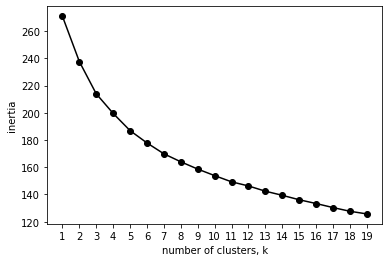

In [31]:
# Vary number of clusters to obtain cluster inertias, and determine optimal number of clusters

ks = range(1, 20)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    km_model = KMeans(n_clusters=k)
    
    # Fit model to samples
    km_model.fit(X)
    
    # Append the inertia to the list of inertias
    inertias.append(km_model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
#plt.show()
plt.savefig('clustering_exp_outputs/13-01-yps-cluster-1-kmeans-inertias.pdf')

In [178]:
# Obtain and plot clusters for k=5
km_model = KMeans(n_clusters=5, random_state=0).fit(X)
km_labels = km_model.labels_
km_centres = km_model.cluster_centers_

In [56]:
km_labels_mod = []
for l in km_labels:
    km_labels_mod.append(l+1)

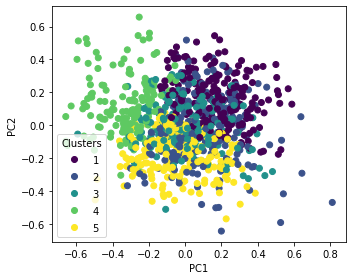

In [182]:
# Visualize the clusters
# PC 1 and 2 separate out the light green cluster
plt.figure(figsize=(5, 4))
scatter = plt.scatter(X[:, 0],X[:, 1], c=km_labels_mod, label=km_labels_mod)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(*scatter.legend_elements(),
                loc="lower left", title="Clusters")
plt.tight_layout()
#plt.show()
plt.savefig('clustering_exp_outputs/13-01-yps-cluster-1-pc1_2-scatter.pdf')

In [ ]:
# Visualize the clusters
# PC 1 and 2 separate out the light green cluster
scatter = plt.scatter(X[:, 0],X[:, 1], c=km_labels, label=km_labels)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(*scatter.legend_elements(),
                loc="lower left", title="Clusters")
plt.savefig('clustering_exp_outputs/13-01-yps-cluster-1-pc1_2-scatter.png')

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


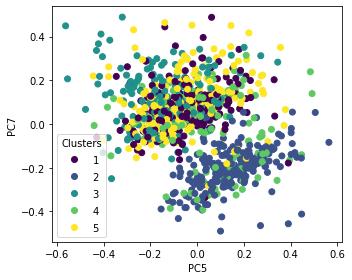

In [183]:
# Visualize the clusters
# PC 5 and 7 separate out the dark blue cluster
plt.figure(figsize=(5, 4))
plt.scatter(X[:, 4],X[:, 6], c=km_labels)
plt.xlabel('PC5')
plt.ylabel('PC7')
plt.legend(*scatter.legend_elements(),
                loc="lower left", title="Clusters")
plt.tight_layout()
plt.savefig('clustering_exp_outputs/13-01-yps-cluster-1-pc5_7-scatter.pdf')

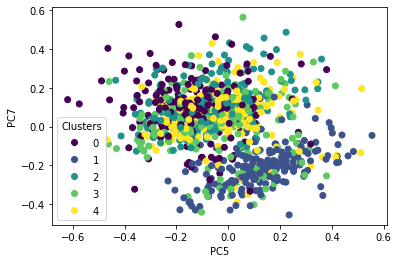

In [197]:
# Visualize the clusters
# PC 5 and 7 separate out the dark blue cluster
plt.scatter(X[:, 4],X[:, 6], c=km_labels)
plt.xlabel('PC5')
plt.ylabel('PC7')
plt.legend(*scatter.legend_elements(),
                loc="lower left", title="Clusters")
plt.savefig('clustering_exp_outputs/13-01-yps-cluster-1-pc5_7-scatter.png')

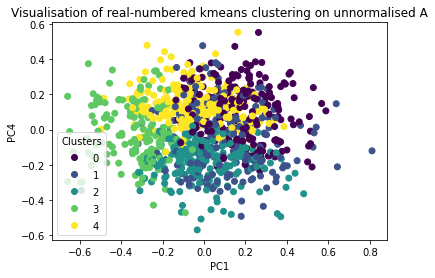

In [39]:
# Visualize the clusters
# PC 1 and 4 separate out the light blue and purple clusters
scatter = plt.scatter(X[:, 0],X[:, 3], c=km_labels, label=km_labels)
plt.title('Visualisation of real-numbered kmeans clustering on unnormalised A')
plt.xlabel('PC1')
plt.ylabel('PC4')
plt.legend(*scatter.legend_elements(),
                loc="lower left", title="Clusters")
plt.show()

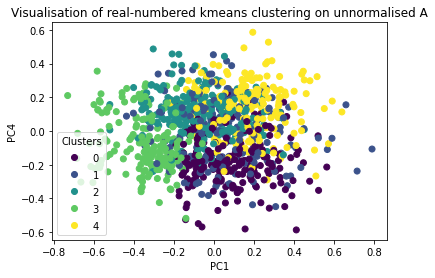

In [173]:
# Visualize the clusters
# PC 1 and 4 separate out the light blue and purple clusters
scatter = plt.scatter(X[:, 0],X[:, 3], c=km_labels, label=km_labels)
plt.title('Visualisation of real-numbered kmeans clustering on unnormalised A')
plt.xlabel('PC1')
plt.ylabel('PC4')
plt.legend(*scatter.legend_elements(),
                loc="lower left", title="Clusters")
plt.show()

In [164]:
# Derive meaning from clusters

# Get position of cluster centres in n dimensional space
ndim_clusters = hstack([L.decode(km_centres.dot(yj)) for yj, L in zip(yp_model.Y, yp_model.L)])

In [165]:
ndim_clusters

array([[21.37667795,  5.        ,  3.        ,  3.        ,  3.        ,
         3.        ,  4.        ,  3.        ,  3.        ,  4.        ,
         3.        ,  3.        ,  3.        ,  3.        ,  3.        ,
         3.        ,  3.        ,  3.        ,  2.        ,  3.        ,
         1.        ,  1.        ],
       [20.0960808 ,  5.        ,  3.        ,  3.        ,  3.        ,
         3.        ,  3.        ,  3.        ,  4.        ,  4.        ,
         2.        ,  2.        ,  3.        ,  3.        ,  3.        ,
         4.        ,  3.        ,  3.        ,  2.        ,  2.        ,
        -1.        , -1.        ],
       [20.4908441 ,  5.        ,  3.        ,  4.        ,  2.        ,
         2.        ,  3.        ,  3.        ,  4.        ,  4.        ,
         2.        ,  2.        ,  3.        ,  3.        ,  3.        ,
         3.        ,  2.        ,  4.        ,  2.        ,  2.        ,
        -1.        ,  1.        ],
       [20.03715065

In [154]:
km_centres

array([[ 0.17827381,  0.16553621,  0.02192637,  0.11003273, -0.04964103,
         0.07197522,  0.076234  , -0.01827074,  1.        ],
       [ 0.09574878, -0.0361328 , -0.00735124, -0.03418911,  0.1398623 ,
        -0.09052058, -0.20257775, -0.05830251,  1.        ],
       [ 0.00446654, -0.00366801, -0.05024955, -0.18286544, -0.13445999,
         0.01514041,  0.10828359,  0.09715176,  1.        ],
       [-0.32638658,  0.12360629, -0.02404777, -0.01797381,  0.04012065,
         0.01035974, -0.02003518, -0.03898075,  1.        ],
       [-0.04680573, -0.1690629 ,  0.04438117,  0.13018631, -0.04452785,
         0.00328428,  0.08988195,  0.01826242,  1.        ]])

In [155]:
Y

array([[ 1.74822909e+00,  9.83897588e-01, -4.46071693e-01,
        -9.29706033e-01,  2.45002732e+00,  2.11960923e+00,
         3.60761728e+00,  2.56597815e+00, -7.00912390e-01,
         3.57579876e+00,  3.93682585e+00,  3.19912675e+00,
        -1.81171729e+00,  1.89510594e+00,  3.61278116e+00,
         3.86741432e+00,  3.69436897e+00,  1.54449867e+00,
        -1.16872855e+00,  3.60082010e+00, -1.83698882e-01,
        -1.76683078e-01],
       [-1.56048469e+00, -5.46031850e-01, -1.06425217e-01,
        -3.71830435e+00, -2.00845221e+00, -1.27043071e+00,
        -1.12883020e+00, -3.16331556e+00, -3.51013788e+00,
         1.91728857e+00,  4.01992984e+00,  2.96844378e+00,
        -2.79914763e+00, -1.06891214e+00, -1.72967211e+00,
        -1.48885896e-01,  1.44680331e+00, -4.61517243e+00,
        -2.56378798e+00, -1.62031699e+00,  1.96507073e+00,
         3.88385166e-01],
       [ 1.00246044e+00, -1.51372163e+00, -1.83423177e+00,
        -2.54387939e+00,  1.38581536e+00,  2.93783319e-01,
    

In [137]:
ndim_clusters_raw = km_centres.dot(Y)
ndim_clusters_raw

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[20.20276287,  5.65008185,  3.17594981,  2.21934529,  2.091866  ,
         1.84922224,  3.50406123,  2.84439837,  2.8626659 ,  4.90157938,
         3.40387291,  3.27669216,  1.9896789 ,  2.78429823,  3.26370704,
         3.85230939,  3.83001643,  2.48041422,  1.37169899,  2.4554863 ,
        -0.52164976,  1.24042833],
       [20.24462629,  5.70647102,  3.3074879 ,  3.22291083,  3.03264488,
         2.73603397,  3.18821261,  2.91151202,  3.42931663,  4.11137498,
         2.21926867,  2.66876955,  2.68508273,  2.97839066,  2.8914354 ,
         3.57432297,  3.04481876,  2.98988764,  2.16417181,  2.13537418,
        -0.41564717, -1.06971725],
       [21.10843776,  4.49234118,  3.28092567,  3.32769975,  2.33974496,
         2.4215043 ,  3.24967767,  2.41969629,  3.348835  ,  3.63951938,
         2.58021112,  2.36703971,  3.54604618,  3.04420625,  2.97926354,
         3.10218033,  2.56073414,  2.76958932,  2.86389006,  2.32541034,
         1.14989023,  1.31230017],
       [20.1681092 

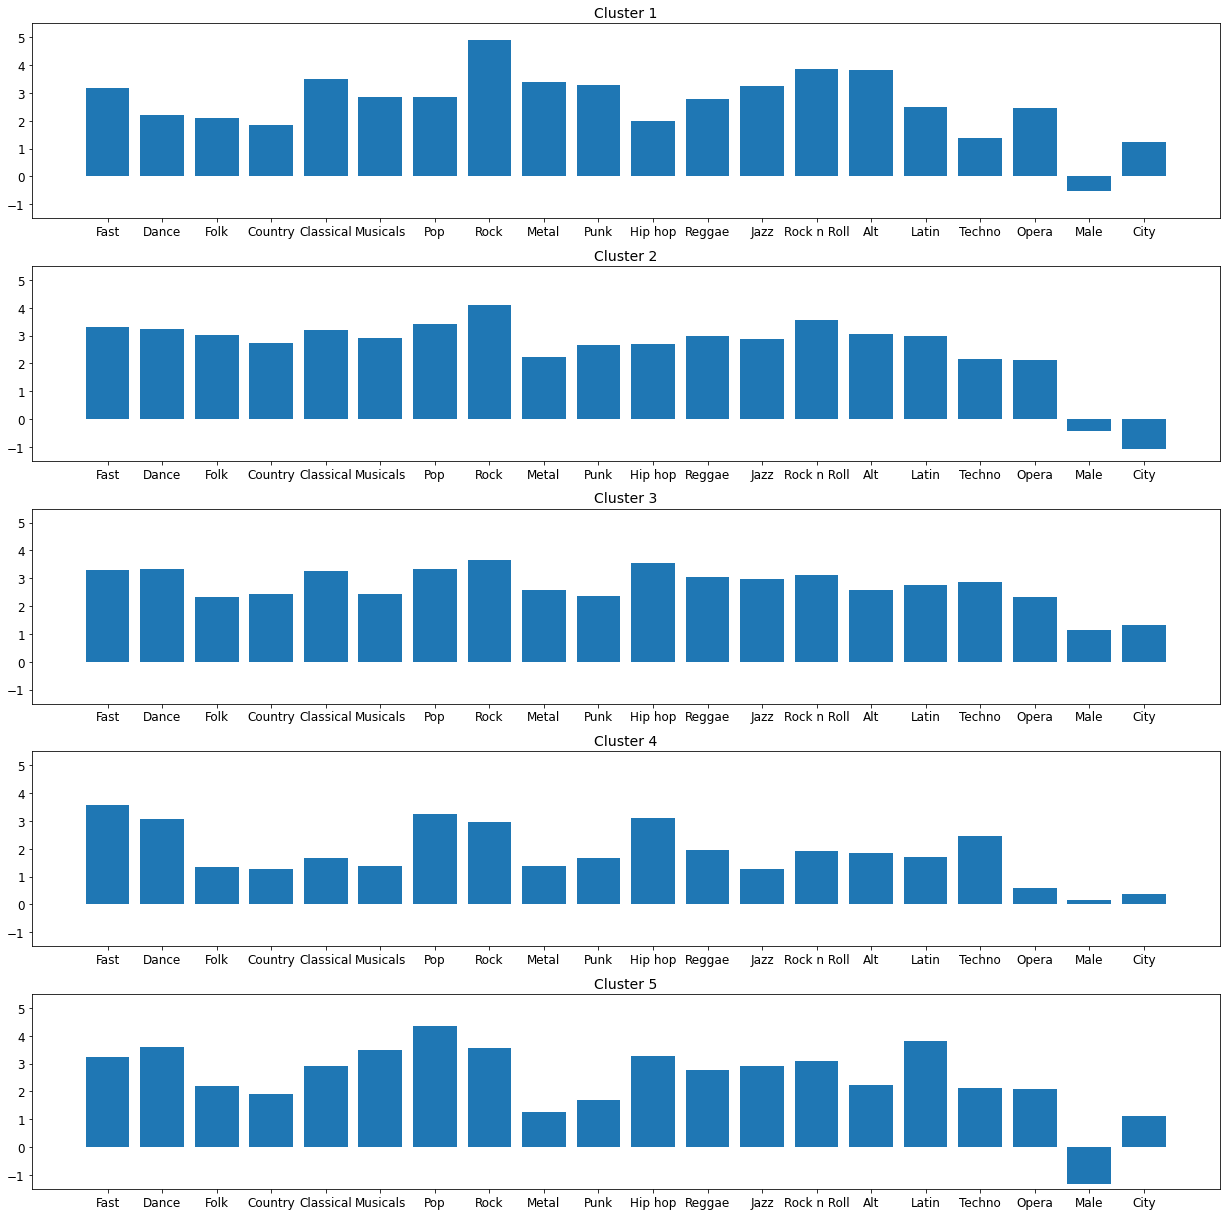

In [54]:
# Visualise the meaning of these cluster centres
tick_labels = ['Fast', 'Dance', 'Folk', 'Country', 'Classical', 'Musicals', 'Pop', 'Rock', 'Metal', \
               'Punk', 'Hip hop', 'Reggae', 'Jazz', 'Rock n Roll', 'Alt', 'Latin', 'Techno', 'Opera', 'Male', 'City']
fig, axs = plt.subplots(5, 1, figsize=(17,17))
for i, ax in enumerate(axs):
    ax.set_title('Cluster {}'.format(i+1), fontsize=14)
    ax.bar(range(20), ndim_clusters_raw[i][2:], tick_label=tick_labels)
    ax.set_ylim(-1.5, 5.5)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
plt.tight_layout()
#plt.show()
plt.savefig('clustering_exp_outputs/13-01-yps-cluster-1-centres.pdf')

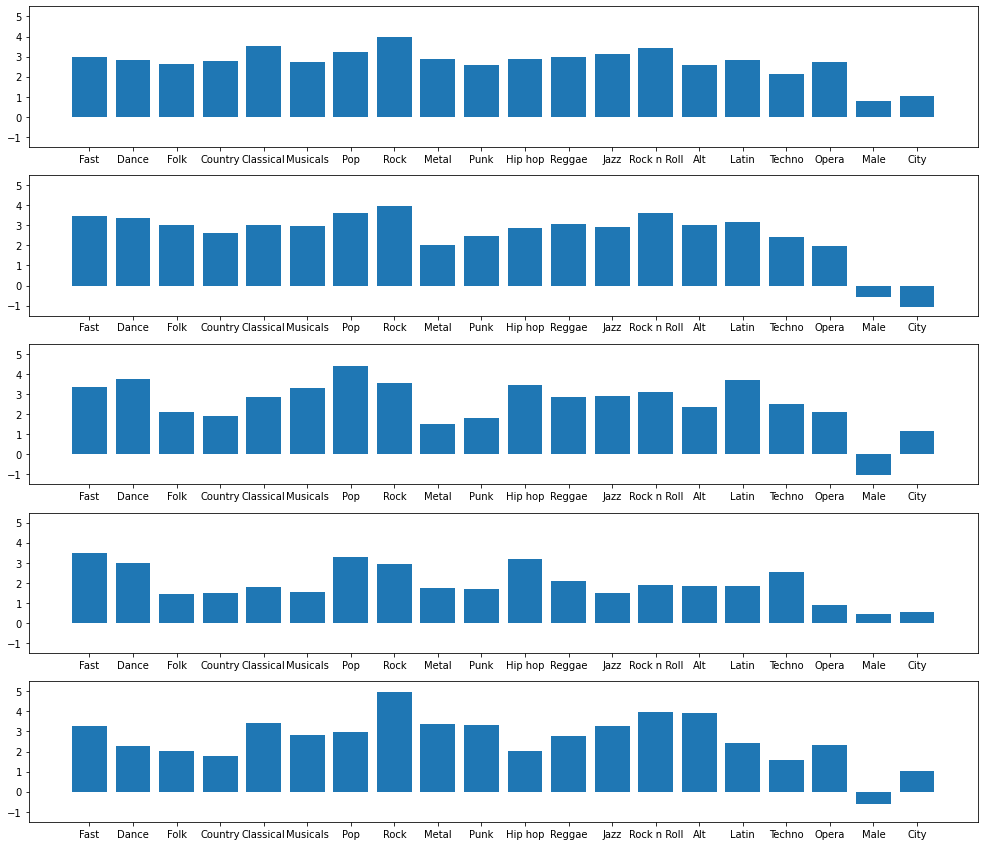

In [235]:
# Visualise the meaning of these cluster centres
tick_labels = ['Fast', 'Dance', 'Folk', 'Country', 'Classical', 'Musicals', 'Pop', 'Rock', 'Metal', \
               'Punk', 'Hip hop', 'Reggae', 'Jazz', 'Rock n Roll', 'Alt', 'Latin', 'Techno', 'Opera', 'Male', 'City']
fig, axs = plt.subplots(5, 1, figsize=(17,15))
for i, ax in enumerate(axs):
    ax.bar(range(20), ndim_clusters_raw[i][2:], tick_label=tick_labels)
    ax.set_ylim(-1.5, 5.5)
plt.savefig('clustering_exp_outputs/13-01-yps-cluster-1-centres.png')

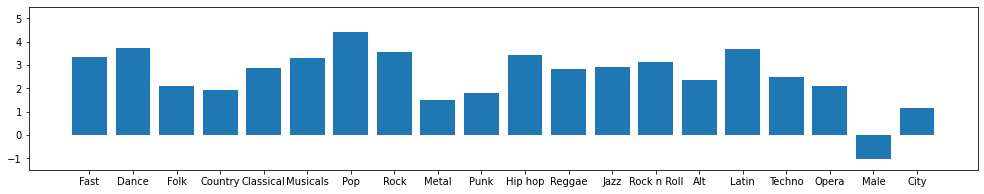

In [228]:
plt.figure(figsize=(17, 3))
plt.bar(range(20), ndim_clusters_raw[2][2:], tick_label=tick_labels)
plt.ylim(-1.5, 5.5)
plt.savefig('clustering_exp_outputs/13-01-yps-cluster-1-c2.png')

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


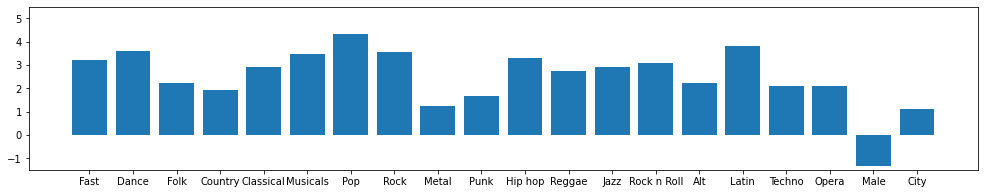

In [62]:
plt.figure(figsize=(17, 3))
plt.bar(range(20), ndim_clusters_raw[4][2:], tick_label=tick_labels)
plt.ylim(-1.5, 5.5)
plt.savefig('clustering_exp_outputs/13-01-yps-cluster-1-c4.pdf')

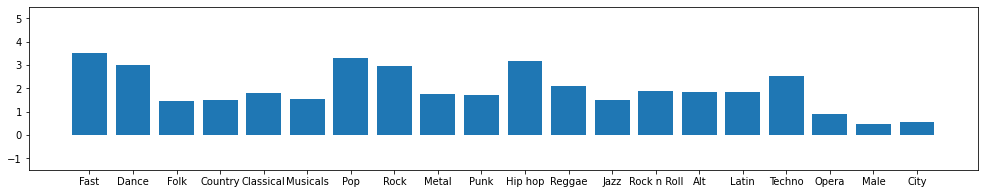

In [234]:
plt.figure(figsize=(17, 3))
plt.bar(range(20), ndim_clusters_raw[3][2:], tick_label=tick_labels)
plt.ylim(-1.5, 5.5)
plt.savefig('clustering_exp_outputs/13-01-yps-cluster-1-c3.png')

In [36]:
# Derive meaning from principal component vectors

pc_subsets = Y[[0, 1, 3, 4, 6],:]

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


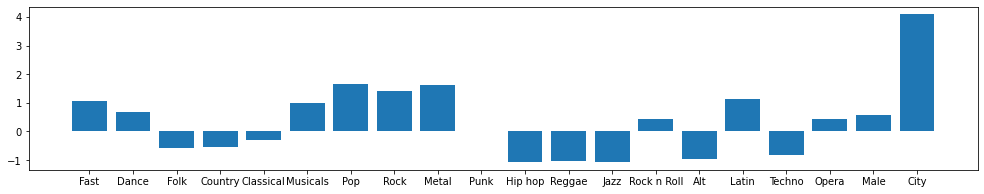

In [76]:
plt.figure(figsize=(17, 3))
plt.bar(range(20), Y[6,2:], tick_label=tick_labels)
#plt.show()
plt.savefig('clustering_exp_outputs/yps-cluster-glrm-pc7.pdf')

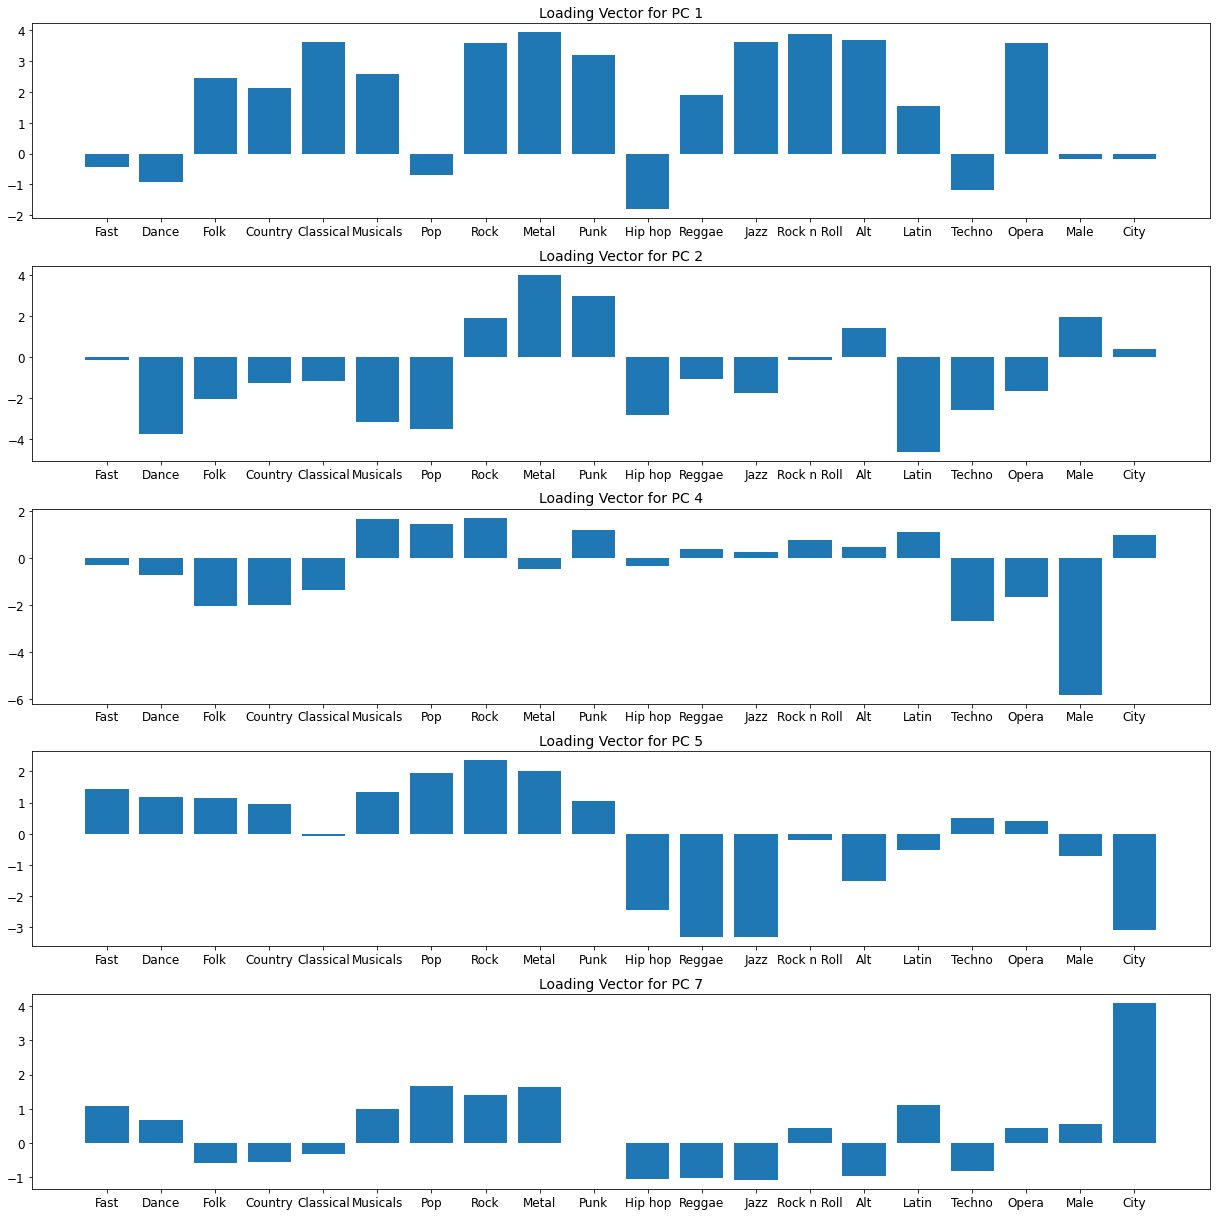

In [66]:
# Visualise the meaning of these cluster centres
tick_labels = ['Fast', 'Dance', 'Folk', 'Country', 'Classical', 'Musicals', 'Pop', 'Rock', 'Metal', \
               'Punk', 'Hip hop', 'Reggae', 'Jazz', 'Rock n Roll', 'Alt', 'Latin', 'Techno', 'Opera', 'Male', 'City']
fig, axs = plt.subplots(5, 1, figsize=(17,17))
PC_list=[1,2,4,5,7]
for i, ax in enumerate(axs):
    ax.set_title('Loading Vector for PC {}'.format(PC_list[i]), fontsize=14)
    ax.bar(range(20), pc_subsets[i][2:], tick_label=tick_labels)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
plt.tight_layout()
#plt.show()
plt.savefig('clustering_exp_outputs/yps-cluster-glrm-pcs.pdf')

In [92]:
Y.shape

(9, 22)

In [94]:
cs_split[0]

[array([20.20276287]),
 array([5.65008185, 3.17594981, 2.21934529, 2.091866  , 1.84922224,
        3.50406123, 2.84439837, 2.8626659 , 4.90157938, 3.40387291,
        3.27669216, 1.9896789 , 2.78429823, 3.26370704, 3.85230939,
        3.83001643, 2.48041422, 1.37169899, 2.4554863 ]),
 array([-0.52164976,  1.24042833])]

In [134]:
# Calculate inertia
cs = ndim_clusters_raw.copy()
cs_split = []
for c in cs:
    c_split = []
    c_split.append(np.array([c[0]]))
    c_split.append(np.array(c[1:20]))
    c_split.append(np.array(c[20:22]))
    cs_split.append(c_split)

inertia_tot = 0
for i, c_split in enumerate(cs_split):
    A_clus = [np.array([A[l][j,:] for j in range(m) if km_labels[j] == i]) for l in range(len(A))]
    inertia = sum(sum(L(samp, c, mask=lm[0]) for samp in Aj) 
                    for L, Aj, lm, c in zip(yp_model.L, A_clus, yp_model.loss_masks, c_split))
    inertia_tot += inertia

In [135]:
inertia_tot.value

20160.530176120894

## GLRM-K-means removing some PCs

In [173]:
X.shape

(1010, 9)

In [174]:
# Obtain and plot clusters for k=5
r_km_model = KMeans(n_clusters=5, random_state=0).fit(X[:,[0,1,2,3,4,5,8]])
r_km_labels = r_km_model.labels_
r_km_centres = r_km_model.cluster_centers_

In [176]:
r_km_centroids_Y = r_km_centres.dot(Y[[0,1,2,3,4,5,8],:])

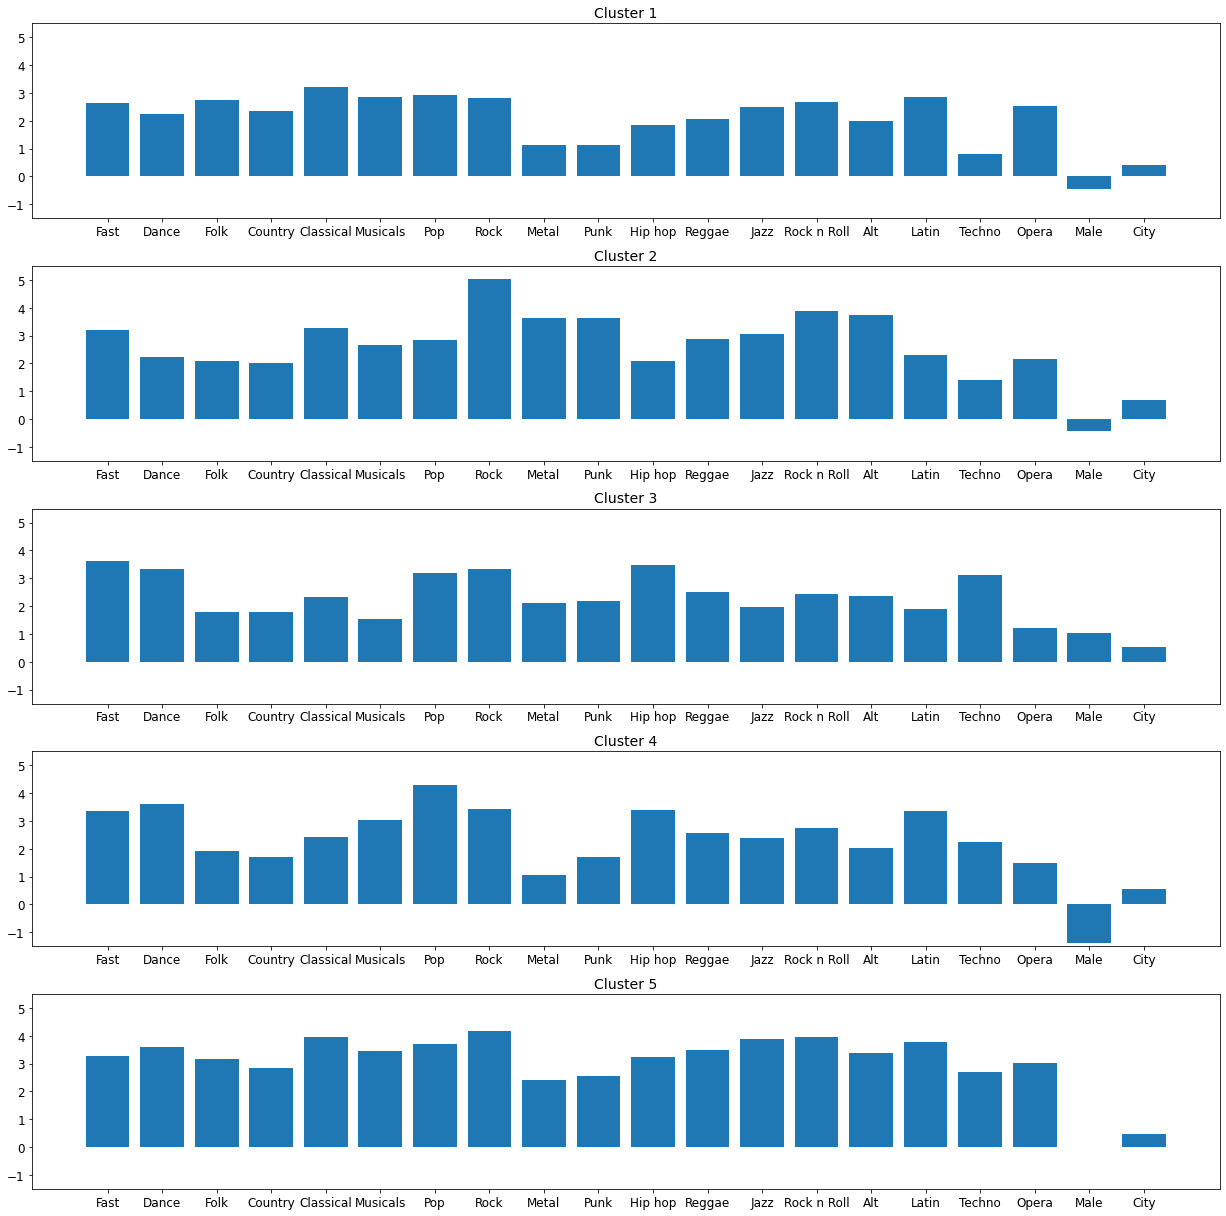

In [177]:
# Visualise the meaning of these cluster centres
tick_labels = ['Fast', 'Dance', 'Folk', 'Country', 'Classical', 'Musicals', 'Pop', 'Rock', 'Metal', \
               'Punk', 'Hip hop', 'Reggae', 'Jazz', 'Rock n Roll', 'Alt', 'Latin', 'Techno', 'Opera', 'Male', 'City']
fig, axs = plt.subplots(5, 1, figsize=(17,17))
for i, ax in enumerate(axs):
    ax.set_title('Cluster {}'.format(i+1), fontsize=14)
    ax.bar(range(20), r_km_centroids_Y[i][2:], tick_label=tick_labels)
    ax.set_ylim(-1.5, 5.5)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
plt.tight_layout()
plt.show()

## Baseline clustering method (on GLRM model)

In [192]:
A_hat = yp_model.predict()

In [193]:
A_hat.shape

(1010, 22)

In [203]:
A[1].shape

(1010, 19)

In [206]:
A_hat_list[0].shape

(1010, 1)

In [205]:
A_hat_list = [A_hat[:,0:1], A_hat[:,1:20], A_hat[:,20:22]]

In [207]:
bl2_centroids, bl2_clusters = generalised_kmeans(A_hat_list, yp_model.L, yp_model.loss_masks, 5, max_iter=10)

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 1, convergence score 0.6006904845088441
Iteration 2, convergence score 0.2749044504895859
Iteration 3, convergence score 0.3104674760339369
Iteration 4, convergence score 0.3657209137997138
Iteration 5, convergence score 0.36015198018043326
Iteration 6, convergence score 0.3449755163376144
Iteration 7, convergence score 0.35835531585660685
Iteration 8, convergence score 0.3449755163376144
Iteration 9, convergence score 0.35835531585660685
Iteration 10, convergence score 0.3449755163376144


In [210]:
yps_km2_model = KMeans(n_clusters=5, random_state=4).fit(A_hat)
yps_km2_labels = yps_km2_model.labels_
yps_km2_centres = yps_km2_model.cluster_centers_

In [211]:
#Calculate inertia

cs = yps_km2_centres.copy()
cs_split = []
for c in cs:
    c_split = []
    c_split.append(np.array([c[0]]))
    c_split.append(np.array(c[1:20]))
    c_split.append(np.array(c[20:22]))
    cs_split.append(c_split)
    
inertia_tot = 0
for i, c_split in enumerate(cs_split):
    A_clus = [np.array([A[l][j,:] for j in range(m) if km_labels[j] == i]) for l in range(len(A))]
    inertia = sum(sum(L(samp, c, mask=lm[0]) for samp in Aj) 
                    for L, Aj, lm, c in zip(yp_model.L, A_clus, yp_model.loss_masks, c_split))
    inertia_tot += inertia

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [212]:
inertia_tot.value

30945.42207010607

### Baseline clustering method (on full rank array)

In [244]:
bl_centroids, bl_clusters = generalised_kmeans(A, yp_model.L, yp_model.loss_masks, 5, max_iter=10, random_state=0)

Iteration 1, convergence score 1.2049424867877374
Iteration 2, convergence score 0.4014178340018472
Iteration 3, convergence score 0.41662391013192446
Iteration 4, convergence score 0.39917231051845536
Iteration 5, convergence score 0.40750606757993985
Iteration 6, convergence score 0.3786102672165777
Iteration 7, convergence score 0.40823792877979304
Iteration 8, convergence score 0.3744709693845363
Iteration 9, convergence score 0.41608381187069143
Iteration 10, convergence score 0.3744709693845363


In [245]:
bl_clusters

array([0., 4., 4., ..., 0., 0., 1.])

In [246]:
bl_centroids

array([[20.44686988,  5.08672771,  3.0024488 ,  3.00442104,  2.01278722,
         2.00553566,  2.00115227,  2.00036083,  3.99561635,  4.00279832,
         1.99226728,  1.99116218,  2.00358126,  2.00875402,  2.01595181,
         1.99682775,  1.99981712,  2.00339048,  1.97811331,  1.05558233,
        -1.00013537,  1.00010505],
       [20.49259387,  5.11516478,  4.00633152,  3.99942183,  2.00569749,
         2.00060063,  1.99196442,  2.00124134,  4.00297172,  2.99907251,
         1.98757768,  1.99044303,  3.99003376,  3.00223909,  1.99137863,
         3.00169229,  1.99765056,  2.98761742,  2.99858735,  0.99833917,
         0.9996577 ,  0.99980166],
       [ 0.        ,  5.00112925,  3.00015016,  2.99973972,  2.00012995,
         2.00015567,  2.9997084 ,  2.00012706,  3.00011059,  4.0002124 ,
         2.00004397,  1.99969135,  2.99996001,  2.99976049,  3.00000014,
         2.00018501,  3.00008603,  1.99984499,  2.00001719,  2.00003954,
        -0.99980492, -0.99941003],
       [21.64212652

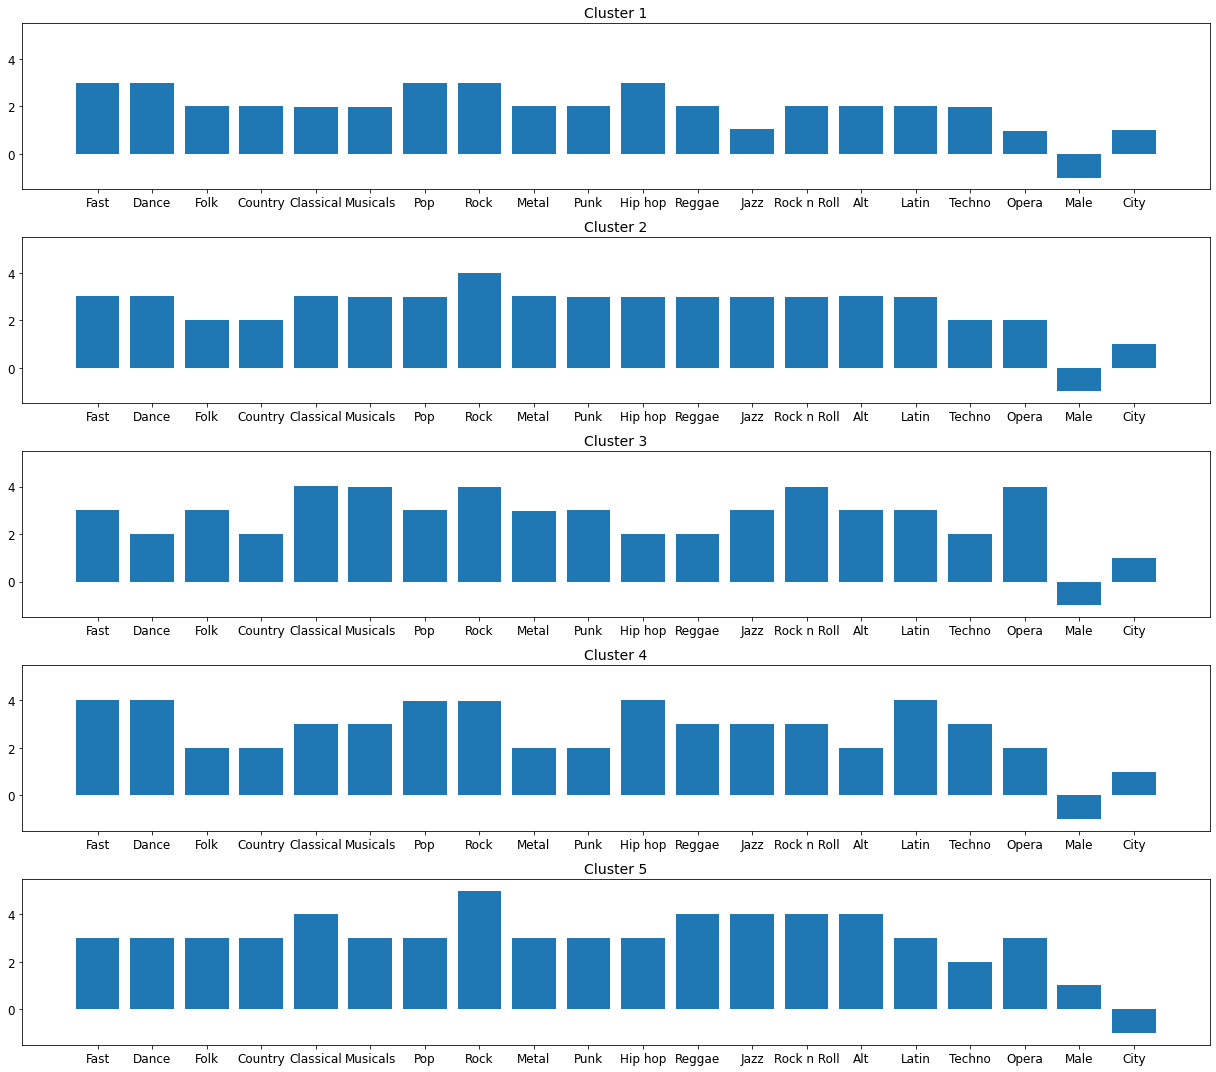

In [116]:
# Visualise the meaning of these cluster centres
tick_labels = ['Fast', 'Dance', 'Folk', 'Country', 'Classical', 'Musicals', 'Pop', 'Rock', 'Metal', \
               'Punk', 'Hip hop', 'Reggae', 'Jazz', 'Rock n Roll', 'Alt', 'Latin', 'Techno', 'Opera', 'Male', 'City']
fig, axs = plt.subplots(5, 1, figsize=(17,15))
for i, ax in enumerate(axs):
    ax.set_title('Cluster {}'.format(i+1), fontsize=14)
    ax.bar(range(20), bl_centroids[i][2:], tick_label=tick_labels)
    ax.set_ylim(-1.5, 5.5)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
plt.tight_layout()
plt.savefig('clustering_exp_outputs/13-01-yps-cluster-1-baseline-centres.pdf')

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


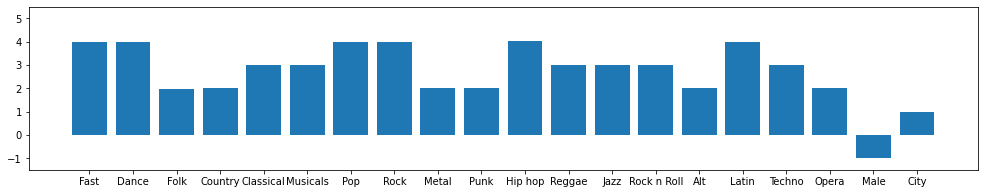

In [119]:
plt.figure(figsize=(17, 3))
plt.bar(range(20), bl_centroids[3][2:], tick_label=tick_labels)
plt.ylim(-1.5, 5.5)
#plt.show()
plt.savefig('clustering_exp_outputs/13-01-yps-cluster-1-baseline-c4.pdf')

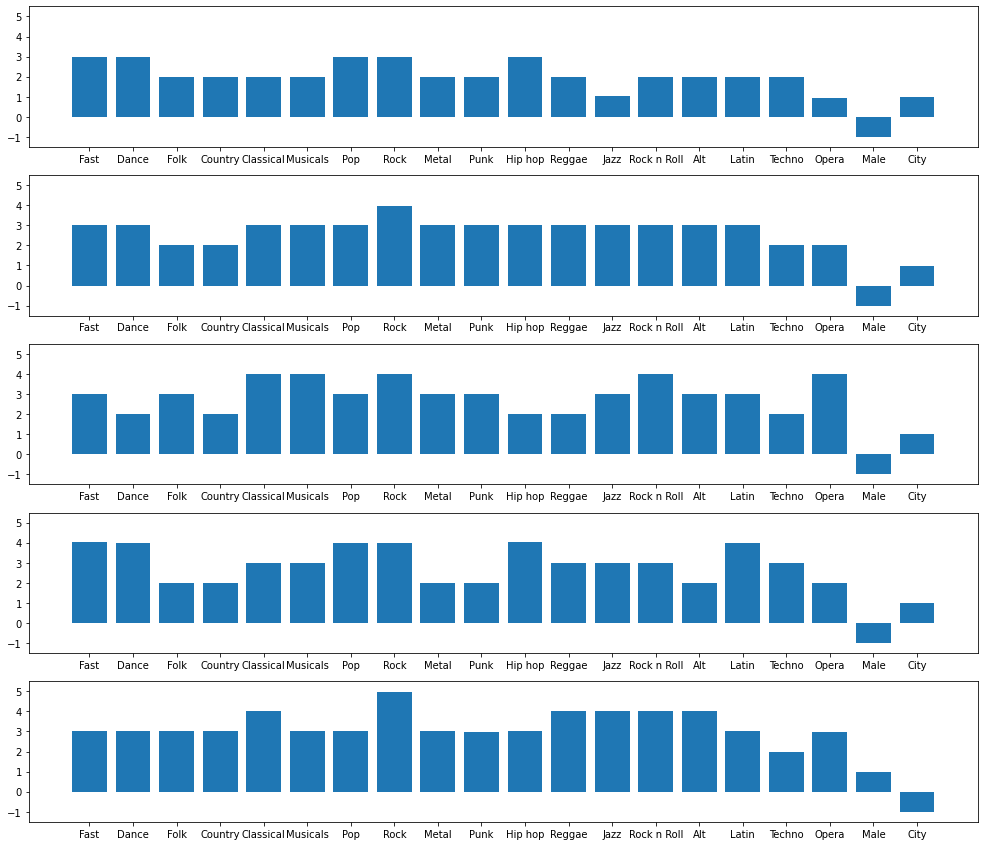

In [236]:
# Visualise the meaning of these cluster centres
tick_labels = ['Fast', 'Dance', 'Folk', 'Country', 'Classical', 'Musicals', 'Pop', 'Rock', 'Metal', \
               'Punk', 'Hip hop', 'Reggae', 'Jazz', 'Rock n Roll', 'Alt', 'Latin', 'Techno', 'Opera', 'Male', 'City']
fig, axs = plt.subplots(5, 1, figsize=(17,15))
for i, ax in enumerate(axs):
    ax.bar(range(20), bl_centroids[i][2:], tick_label=tick_labels)
    ax.set_ylim(-1.5, 5.5)
plt.savefig('clustering_exp_outputs/13-01-yps-cluster-1-baseline-centres.png')

In [247]:
#Calculate inertia

cs = bl_centroids.copy()
cs_split = []
for c in cs:
    c_split = []
    c_split.append(np.array([c[0]]))
    c_split.append(np.array(c[1:20]))
    c_split.append(np.array(c[20:22]))
    cs_split.append(c_split)
    
inertia_tot = 0
for i, c_split in enumerate(cs_split):
    A_clus = [np.array([A[l][j,:] for j in range(m) if bl_clusters[j] == i]) for l in range(len(A))]
    inertia = sum(sum(L(samp, c, mask=lm[0]) for samp in Aj) 
                    for L, Aj, lm, c in zip(yp_model.L, A_clus, yp_model.loss_masks, c_split))
    inertia_tot += inertia

In [248]:
inertia_tot.value

18940.58763729284

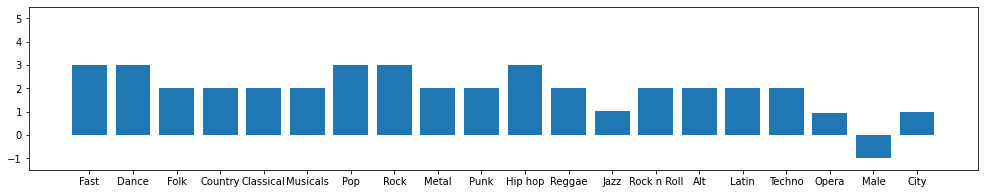

In [231]:
plt.figure(figsize=(17, 3))
plt.bar(range(20), bl_centroids[0][2:], tick_label=tick_labels)
plt.ylim(-1.5, 5.5)
plt.savefig('clustering_exp_outputs/13-01-yps-cluster-1-baseline-c0.png')

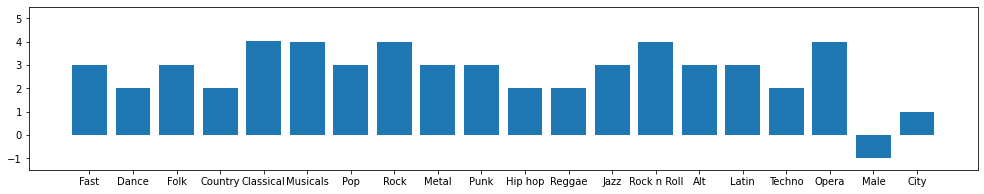

In [233]:
plt.figure(figsize=(17, 3))
plt.bar(range(20), bl_centroids[2][2:], tick_label=tick_labels)
plt.ylim(-1.5, 5.5)
plt.savefig('clustering_exp_outputs/13-01-yps-cluster-1-baseline-c2.png')

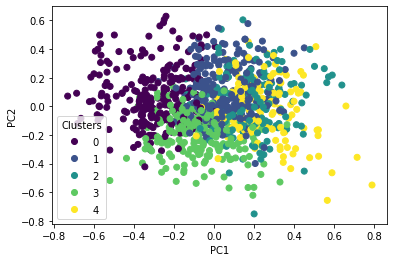

In [203]:
# Visualize the clusters
# PC 1 and 2 separate out the light green cluster
scatter = plt.scatter(X[:, 0],X[:, 1], c=bl_clusters, label=bl_clusters)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(*scatter.legend_elements(),
                loc="lower left", title="Clusters")
plt.show()

## Regular K-means

In [277]:
yps_km_model = KMeans(n_clusters=5, random_state=0).fit(hstack(A))
yps_km_labels = yps_km_model.labels_
yps_km_centres = yps_km_model.cluster_centers_

In [111]:
hstack(A)

array([[20.,  5.,  3., ...,  1., -1., -1.],
       [19.,  4.,  4., ...,  1., -1.,  1.],
       [20.,  5.,  5., ...,  3., -1.,  1.],
       ...,
       [18.,  4.,  3., ...,  1., -1.,  1.],
       [25.,  5.,  3., ...,  1., -1.,  1.],
       [21.,  5.,  5., ...,  1.,  1., -1.]])

In [109]:
yps_km_centres

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[ 0.00000000e+00,  4.42857143e+00,  3.00000000e+00,
         3.14285714e+00,  2.14285714e+00,  2.14285714e+00,
         3.42857143e+00,  2.14285714e+00,  3.28571429e+00,
         3.57142857e+00,  1.85714286e+00,  2.42857143e+00,
         3.42857143e+00,  2.71428571e+00,  3.00000000e+00,
         2.28571429e+00,  2.71428571e+00,  2.42857143e+00,
         2.14285714e+00,  2.00000000e+00, -2.85714286e-01,
        -1.42857143e-01],
       [ 1.94199288e+01,  4.79359431e+00,  3.26334520e+00,
         3.60498221e+00,  2.80782918e+00,  2.54804270e+00,
         3.65480427e+00,  3.53736655e+00,  3.85765125e+00,
         3.86476868e+00,  2.12099644e+00,  2.38434164e+00,
         3.18505338e+00,  3.10320285e+00,  3.56939502e+00,
         3.62989324e+00,  3.04626335e+00,  3.77224199e+00,
         2.64412811e+00,  2.73665480e+00, -4.69750890e-01,
         3.41637011e-01],
       [ 2.59280576e+01,  4.55395683e+00,  3.28776978e+00,
         3.19424460e+00,  2.63309353e+00,  2.28776978e+00,
    

In [278]:
#Calculate inertia

cs = yps_km_centres.copy()
cs_split = []
for c in cs:
    c_split = []
    c_split.append(np.array([c[0]]))
    c_split.append(np.array(c[1:20]))
    c_split.append(np.array(c[20:22]))
    cs_split.append(c_split)
    
inertia_tot = 0
for i, c_split in enumerate(cs_split):
    A_clus = [np.array([A[l][j,:] for j in range(m) if yps_km_labels[j] == i]) for l in range(len(A))]
    inertia = sum(sum(L(samp, c, mask=lm[0]) for samp in Aj) 
                    for L, Aj, lm, c in zip(yp_model.L, A_clus, yp_model.loss_masks, c_split))
    inertia_tot += inertia

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [279]:
inertia_tot.value

20800.09697928881

## Other Analysis

In [280]:
# Calculate standard deviation of inertias

a = [20354, 20389, 20374, 20300, 20304]
b = [18771, 18862, 18796, 18868, 18940]
c = [20800, 20786, 20786, 20800, 20800]

print(mean(a), mean(b), mean(c))
print(stdev(a), stdev(b), stdev(c))

20344.2 18847.4 20794.4
40.49938271134512 66.50413520977474 7.6681158050723255
